# RQ2. How does interpretability impacts training?

1. Occlude high-ranked RoIs, train and measure the performance drop
2. Train ML from saliency dict, train and measure their performance drop

### 1. Occlusion Training

In [1]:
%cd ..
from pathlib import Path

import pandas as pd

from sage.xai.atlas import get_atlas
from sage.xai.atlas_overlap import project_to_atlas
from RQ.weight_parser import WeightAvg
ASSET_DIR = Path("./assets").absolute()

%cd RQ
resnet10 = WeightAvg(model_name="resnet10")
PERF = resnet10.test_performance

INDEX_COL = "mask_index"

def parse_dir(path: Path) -> int:
    if isinstance(path, Path):
        path = path.stem
    idx = path if path.isnumeric() else path.split(" ")[1]
    return int(idx)


MASK_DIR = ASSET_DIR / "occlusion-result"

with open(ASSET_DIR / "dkt_indices.txt", mode="r") as f:
    full_indices = set([int(s.strip()) for s in f.readlines()])

success = MASK_DIR / "success"
failure = MASK_DIR / "failure"
non_proc = MASK_DIR / "mask-weights"

success_pids = set([parse_dir(s) for s in success.glob("*")])
failure_pids = set([parse_dir(s) for s in failure.glob("*")])
non_proc_pids = set([parse_dir(s) for s in non_proc.glob("*")])

full_indices - success_pids

/home/daehyun/codespace/brain-age-prediction


/tmp/ipykernel_6561/1371569480.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/daehyun/.conda/envs/age/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
INFO:/home/daehyun/codespace/brain-age-prediction/RQ/weight_parser.py:Load all seeds: [42, 43, 44]


/home/daehyun/codespace/brain-age-prediction/RQ


{251, 252, 253, 254, 255}

In [2]:
# Checking if every training has train.log file
success_dirs = sorted(success.glob("*"))
for _dir in success_dirs:
    for f in _dir.glob("*"):
        file = str(f).split("/")[-1]
        has_log = file == ("train.log")
        if has_log:
            break
    if not has_log:
        print(_dir)
        
def parse_log(file: Path) -> dict:
    with file.open(mode="r") as f:
        log = [s.strip() for s in f.readlines()]
    si = [idx for idx, s in enumerate(log) if '- MSE:' in s]
    if len(si):
        si = si[0]
    else:
        print(f"Log corrupted: {file}")
        return
    mlog = log[si:si+3]
    metrics = dict()
    for _log in mlog:
        v = float(_log.strip().split(" ")[-1])
        k = _log.strip().split(":")[-2][-3:].strip()
        metrics[k] = v
    return metrics

# Checking if every training has train.log file
df = dict()
for _dir in success_dirs:
    for f in _dir.glob("*"):
        file = str(f).split("/")[-1]
        has_log = file == ("train.log")
        if has_log:
            perf = parse_log(file=f)
            if perf is not None:
                df[int(_dir.stem)] = perf
            break
    if not has_log:
        print(_dir)

df = pd.DataFrame(df).T

In [3]:
dkt = get_atlas(atlas_name="dkt")
def get_xai_dict(df: pd.DataFrame, metric_key: str = "MSE") -> dict:
    assert metric_key in {"MSE", "MAE", "R2"}
    metrics = df[metric_key]
    metrics = metrics - PERF[metric_key.lower()]
    metrics = metrics.to_dict()
    metrics = {dkt.get_roi_name(k): v for k, v in metrics.items()}
    return metrics


plot_kwargs = dict(atlas=dkt, use_abs=False, threshold=0)
title = lambda k: f"Average {k}: {PERF[k.lower()]:.3f}"
metric = lambda k: get_xai_dict(df=df, metric_key=k)

INFO:/home/daehyun/codespace/brain-age-prediction/sage/xai/atlas.py:Load dkt atlas.


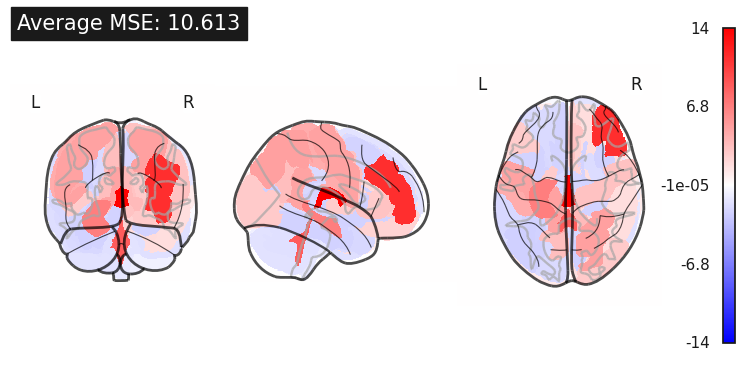

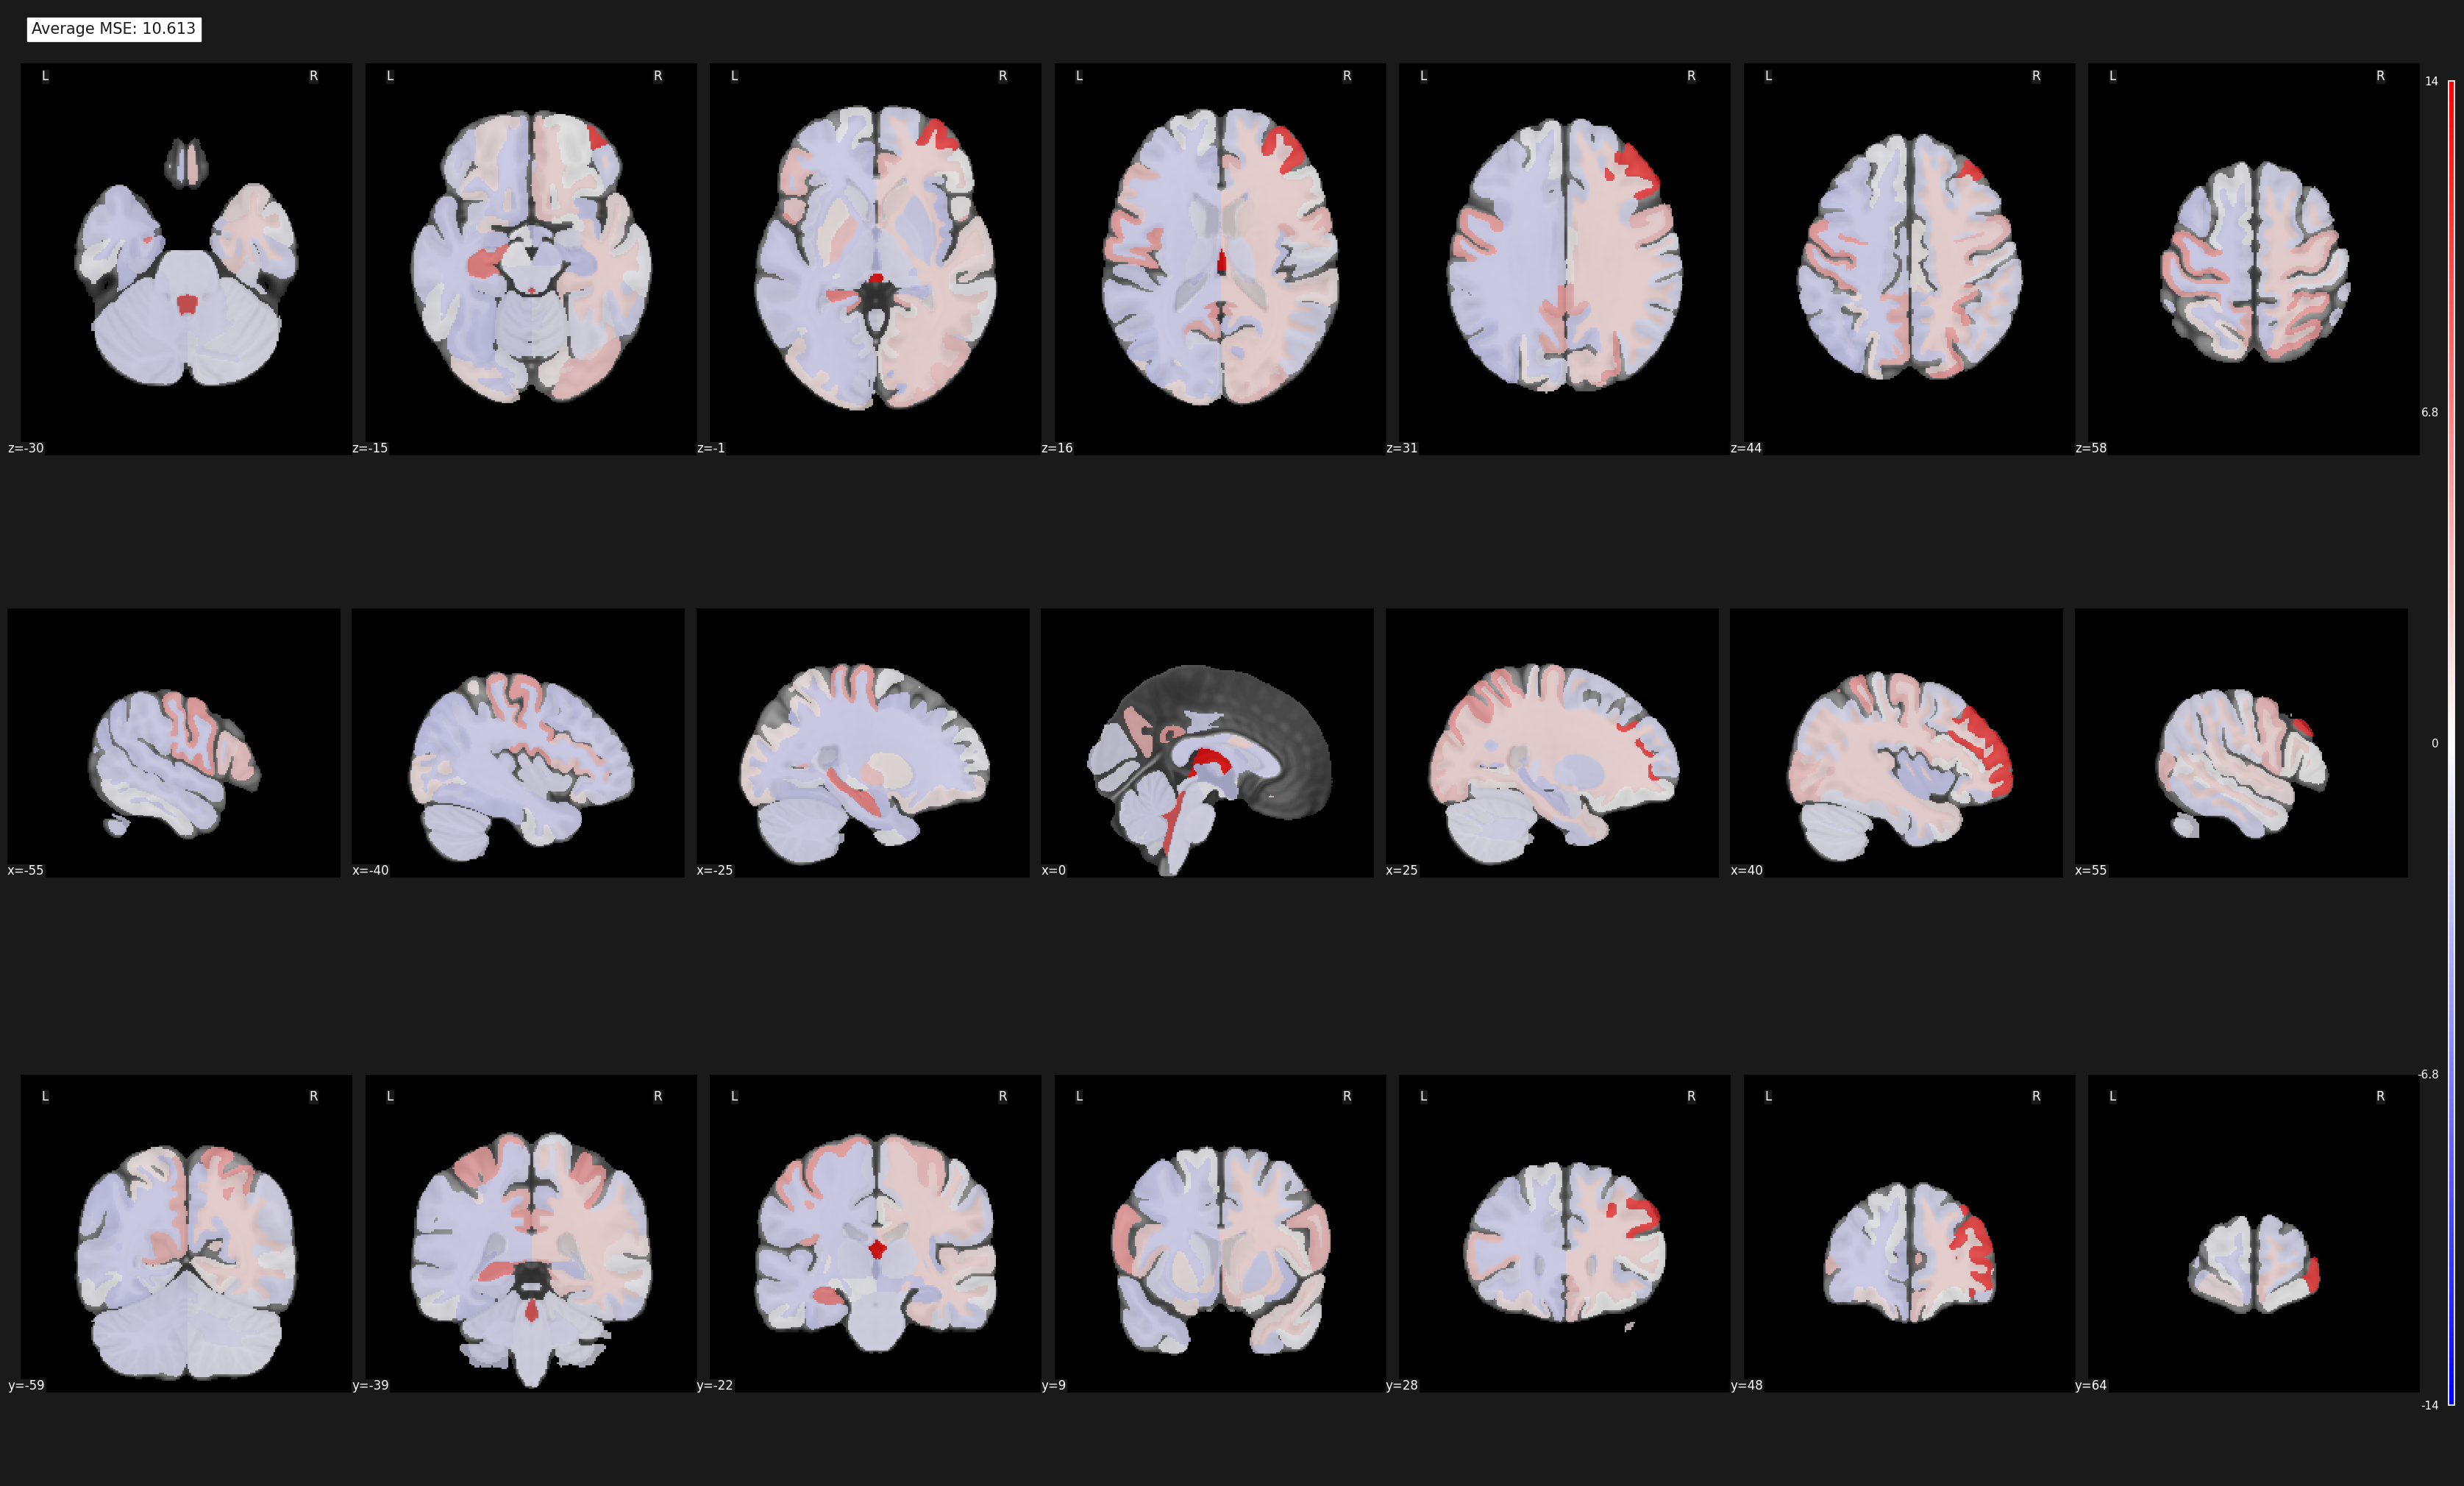

In [4]:
metric_key = "MSE"
_ = project_to_atlas(xai_dict=metric(k=metric_key), title=title(k=metric_key), **plot_kwargs)

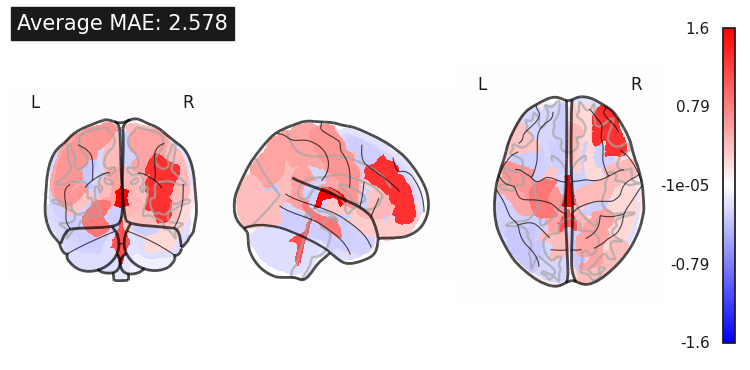

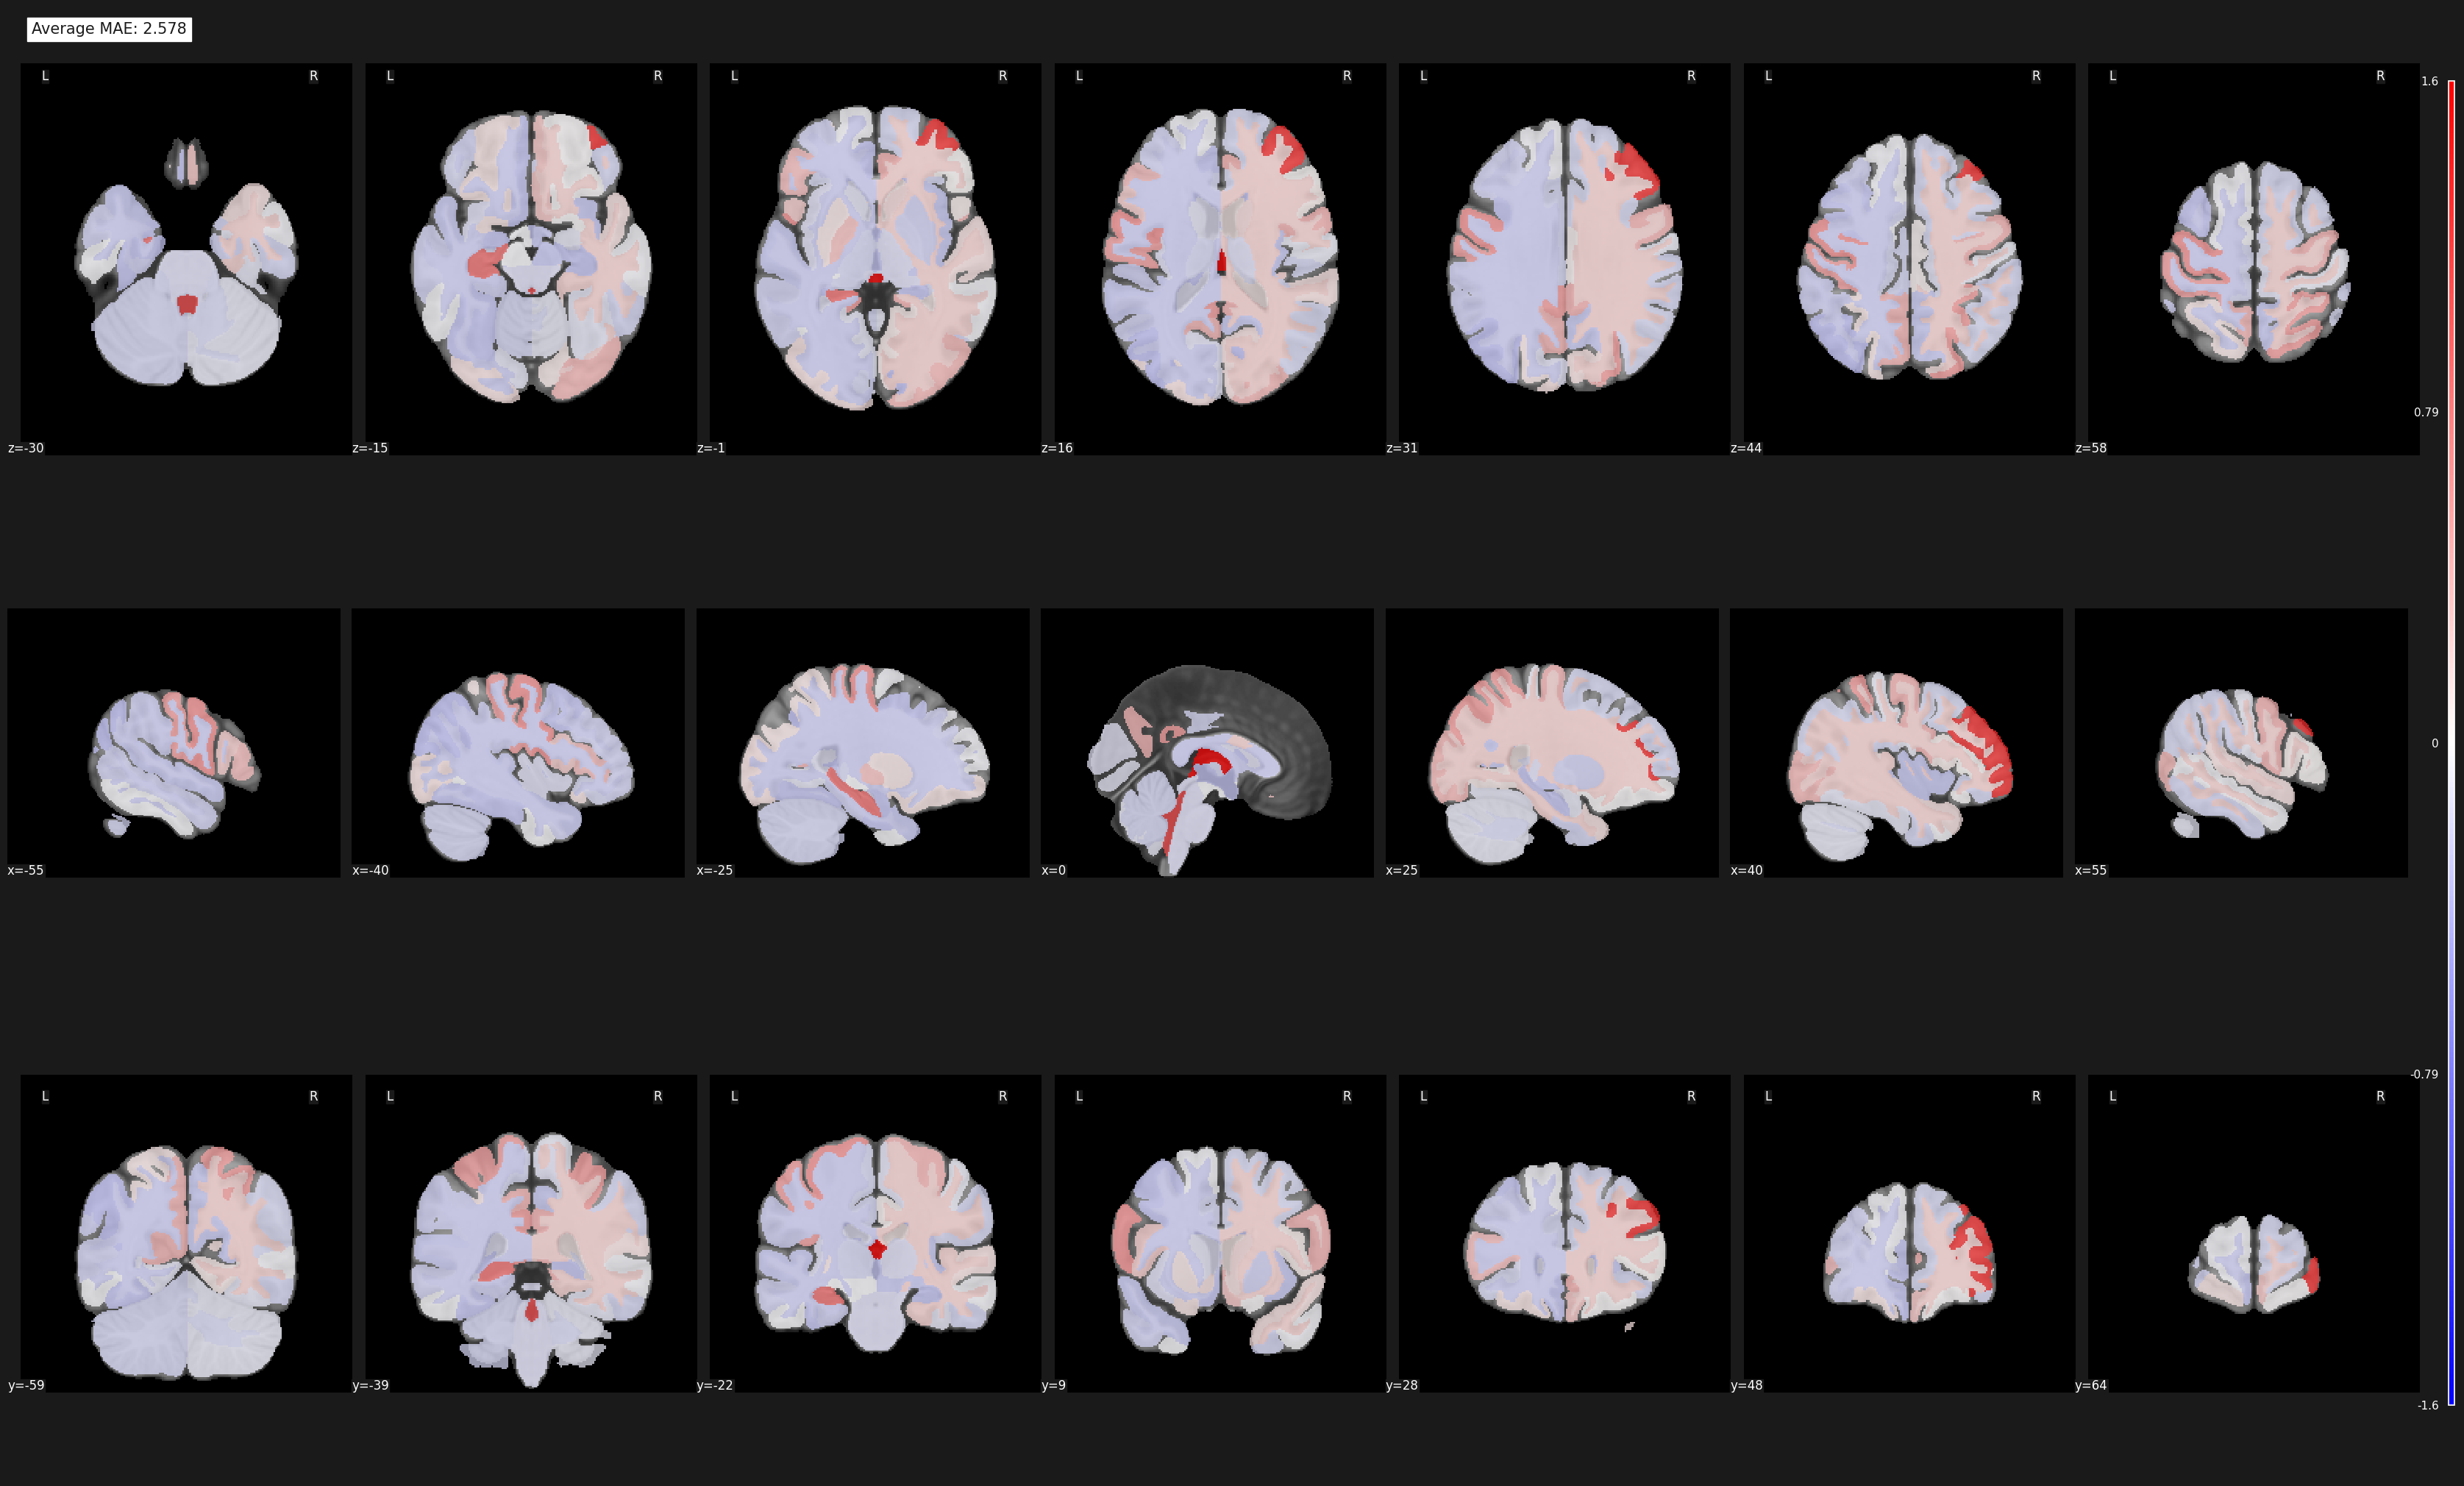

In [5]:
metric_key = "MAE"
_ = project_to_atlas(xai_dict=metric(k=metric_key), title=title(k=metric_key), **plot_kwargs)

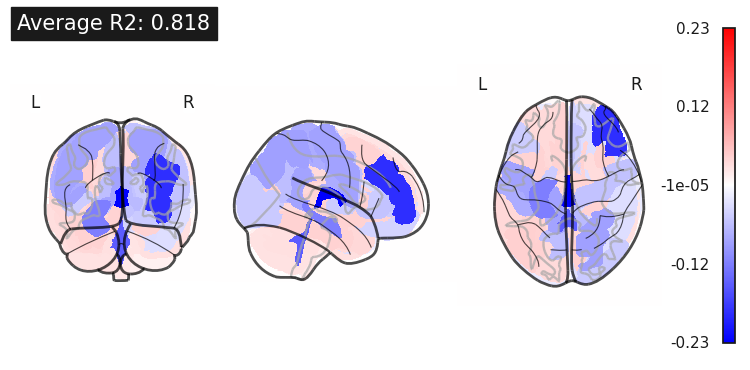

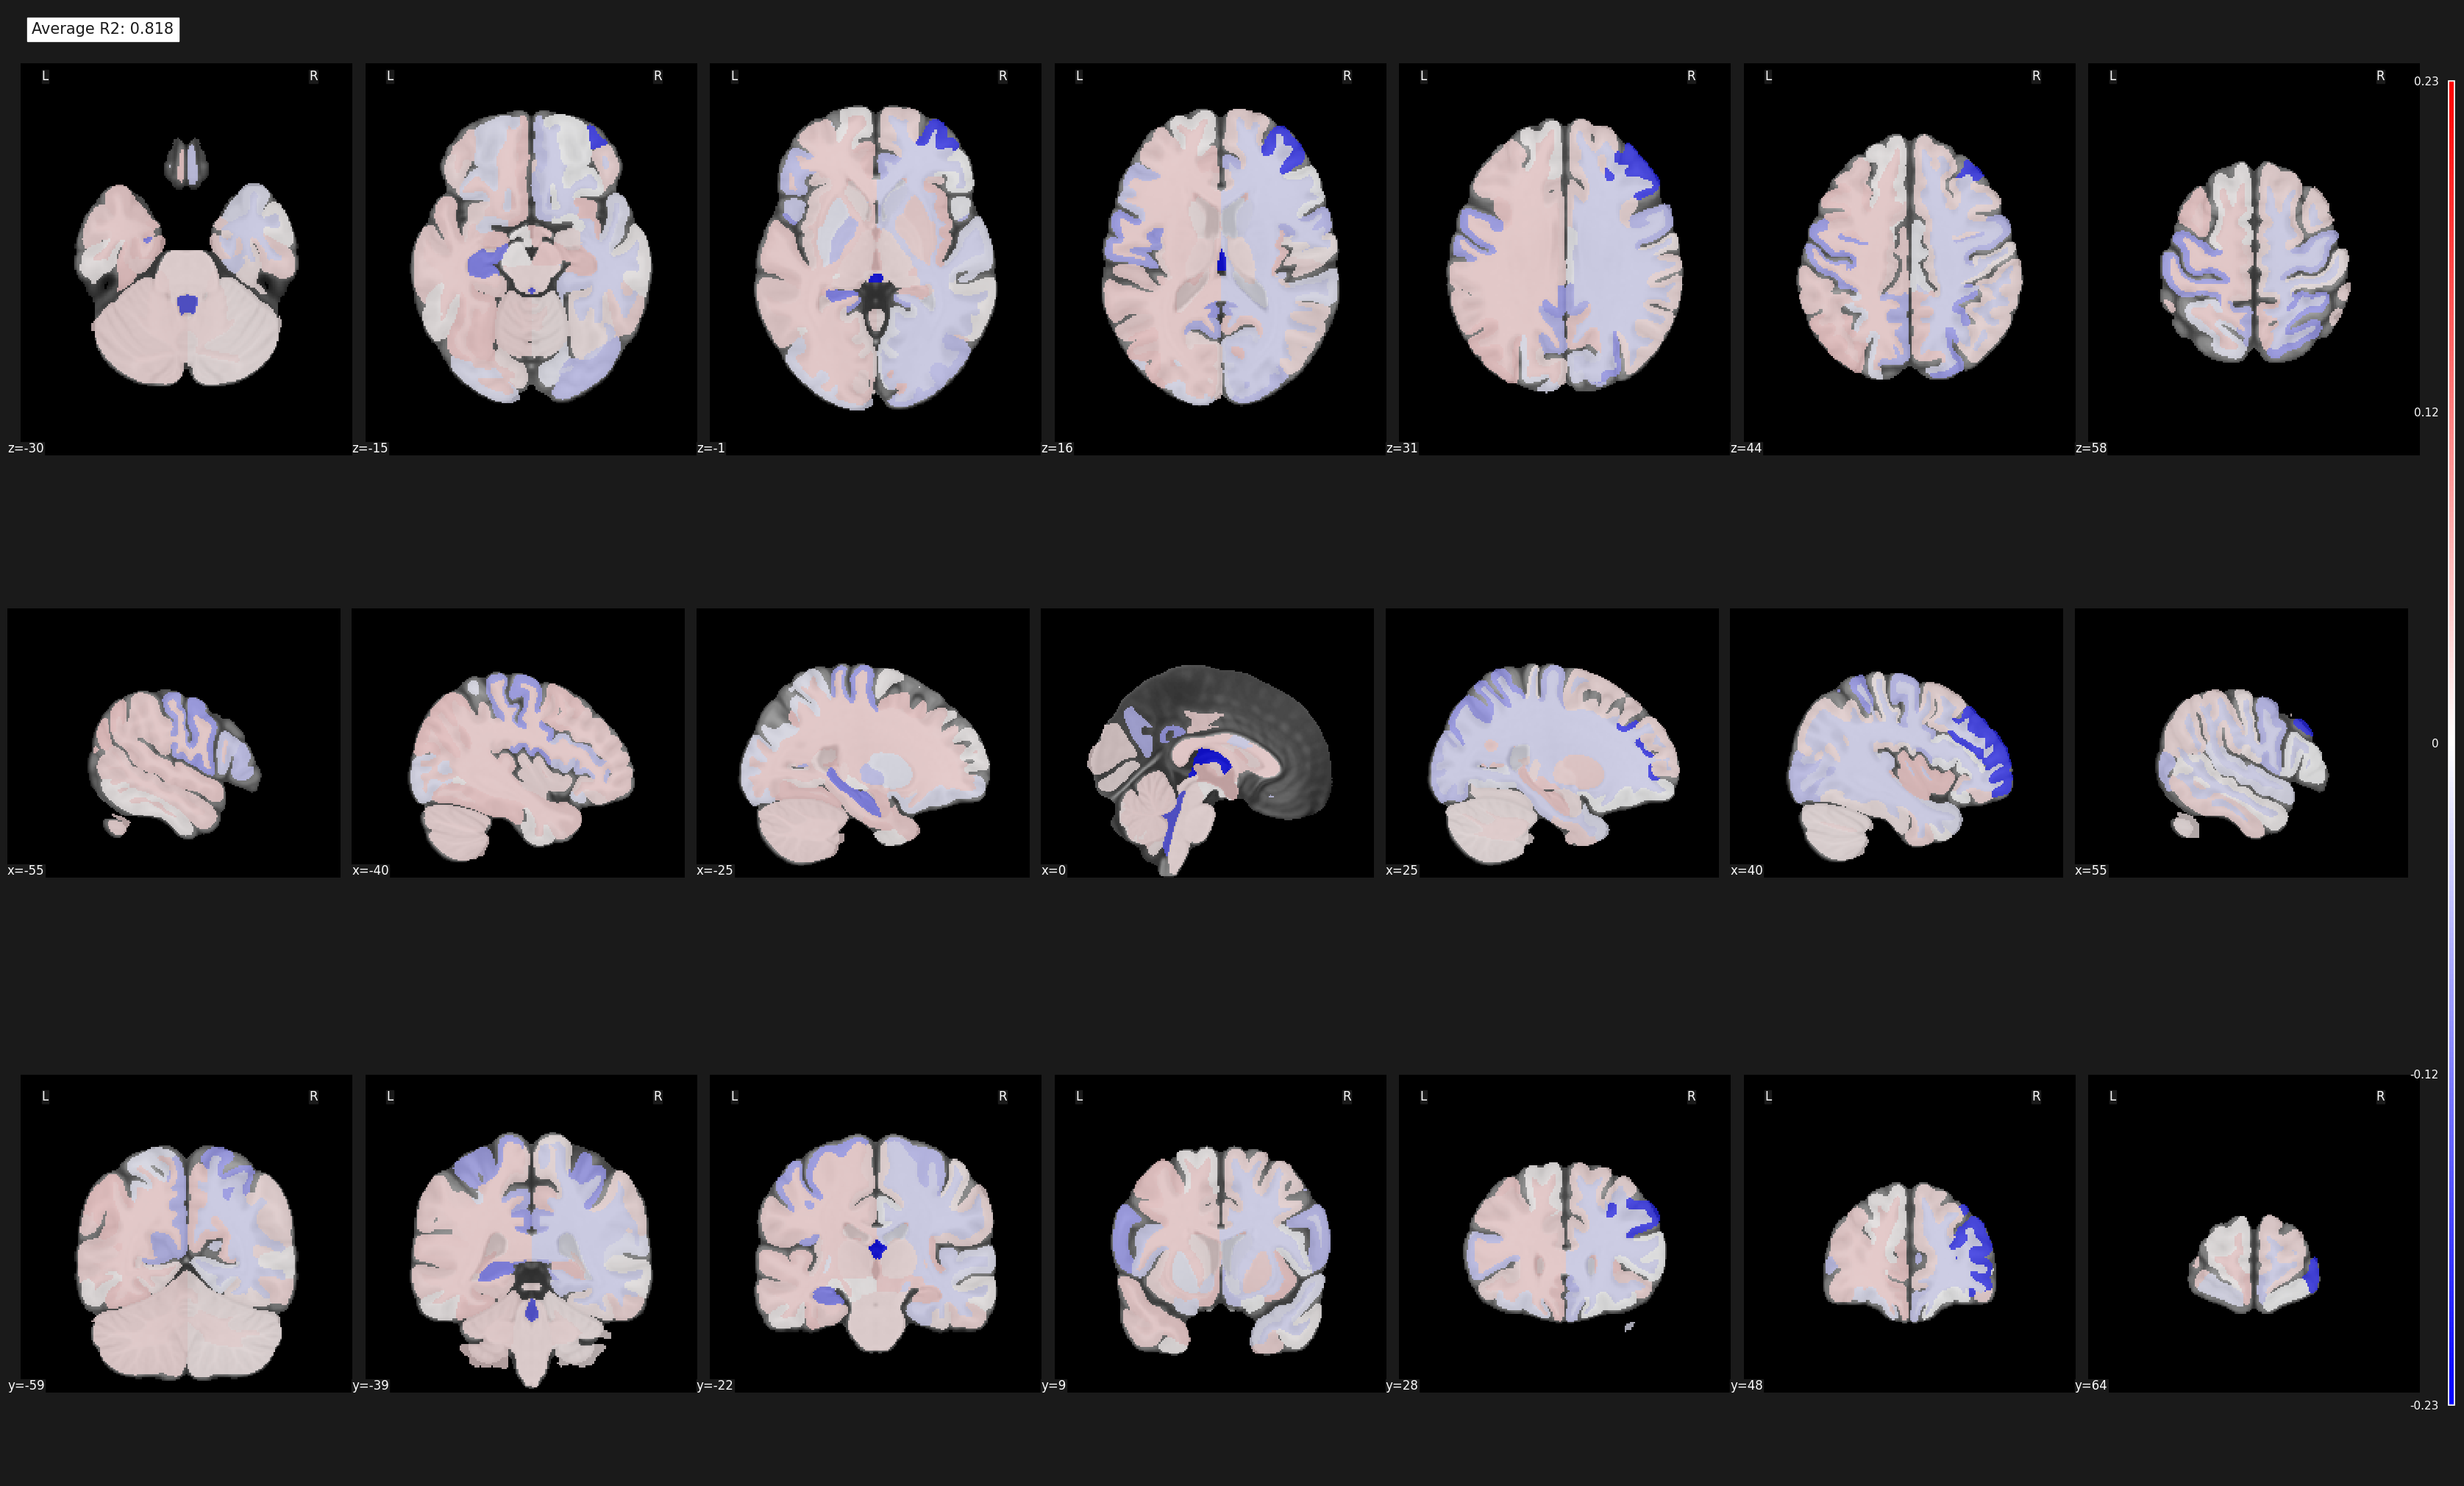

In [6]:
metric_key = "R2"
_ = project_to_atlas(xai_dict=metric(k=metric_key), title=title(k=metric_key), **plot_kwargs)